# Using Sep and Astropy FITS Routines to plot NIRCAM image of NGC 3324

Import the numpy and sep modules

In [1]:
import numpy as np
import sep

Do additional setup for reading the image and displaying plots using astropy fits

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

# Set the figure size for all figures
rcParams['figure.figsize'] = [15., 10.]

Use astropy fits to read image into standard 2D numpy array

In [3]:
hdu_1 = fits.open("./MAST/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits")
print(hdu_1.info())
data = hdu_1[1].data

# Need to do byteswap operation because astropy.io.fits returns 
# big-endian byte order arrays, even on little-endian machines. 
data = data.astype(data.dtype.newbyteorder('='))

print(np.shape(data))

Filename: ./MAST/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     365   ()      
  1  SCI           1 ImageHDU        75   (14339, 8582)   float32   
  2  ERR           1 ImageHDU        10   (14339, 8582)   float32   
  3  CON           1 ImageHDU        10   (14339, 8582, 6)   int32   
  4  WHT           1 ImageHDU         9   (14339, 8582)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (14339, 8582)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (14339, 8582)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (14339, 8582)   float32   
  8  HDRTAB        1 BinTableHDU    532   160R x 261C   [23A, 5A, 3A, 45A, 6A, 13A, 7A, 5A, 6A, 7A, 10A, 4A, L, D, D, 32A, 50A, 32A, 21A, 3A, 3A, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 14A, 23A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 8A, 8A, 5A, D, D, D, D, D, D, 27A, D, D, 

## Rescale image data and display the image

In [4]:
# The code for the rescale_image is derived from ASTR-19 class code
def rescale_image(data,vmin=0.5,vmax=100):
    data_tmp = data.copy()

    # find the mean of the data, excluding NaN
    m = np.nanmean(data_tmp)

    # set cutoffs using vmin/vmax
    vpmin = vmin * m
    vpmax = vmax * m
    data_tmp[data_tmp < vpmin] = vpmin
    data_tmp[data_tmp > vpmax] = vpmax
    
    # replace NaN by vpmin
    data_tmp = np.nan_to_num(data_tmp,nan=vpmin)

    # scale using log base 10
    data_tmp = np.log10(data_tmp)
    return data_tmp

In [5]:
# scale the data and take care of NaN
data = rescale_image(data,vmin=0.5,vmax=100)

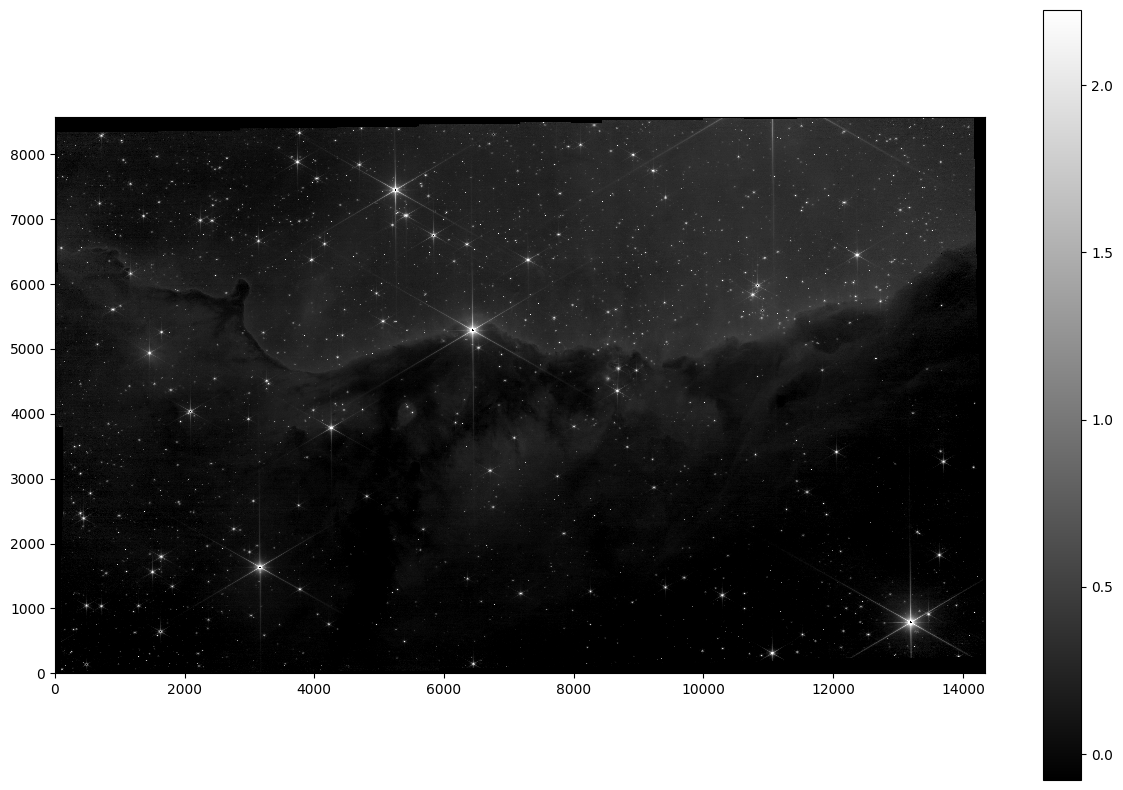

In [6]:
# display the image and save it into a PNG file
plt.imshow(data, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('NGC3324GrayImage.png')

## Background Subtraction 
Lets measure the spatially varying background on the image in order to be able to do source detection. As a result, we get a spatially varying background and spatially varying background noise level.

In [7]:
bkg = sep.Background(data, mask=None, bw=256, bh=256)
print(bkg.globalback)
print(bkg.globalrms)

0.06524530798196793
0.024211300536990166


In [8]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()

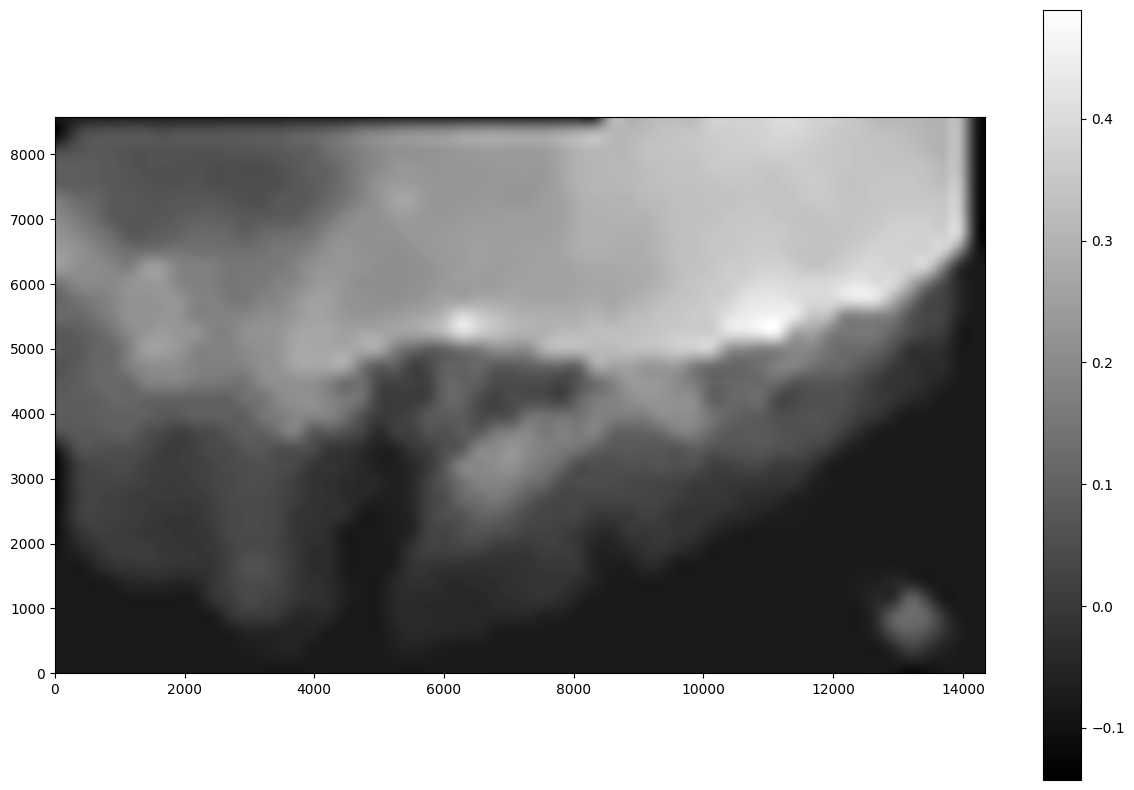

In [9]:
# show the background and save the image into a PNG file
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('NGC3324Background.png')

In [10]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

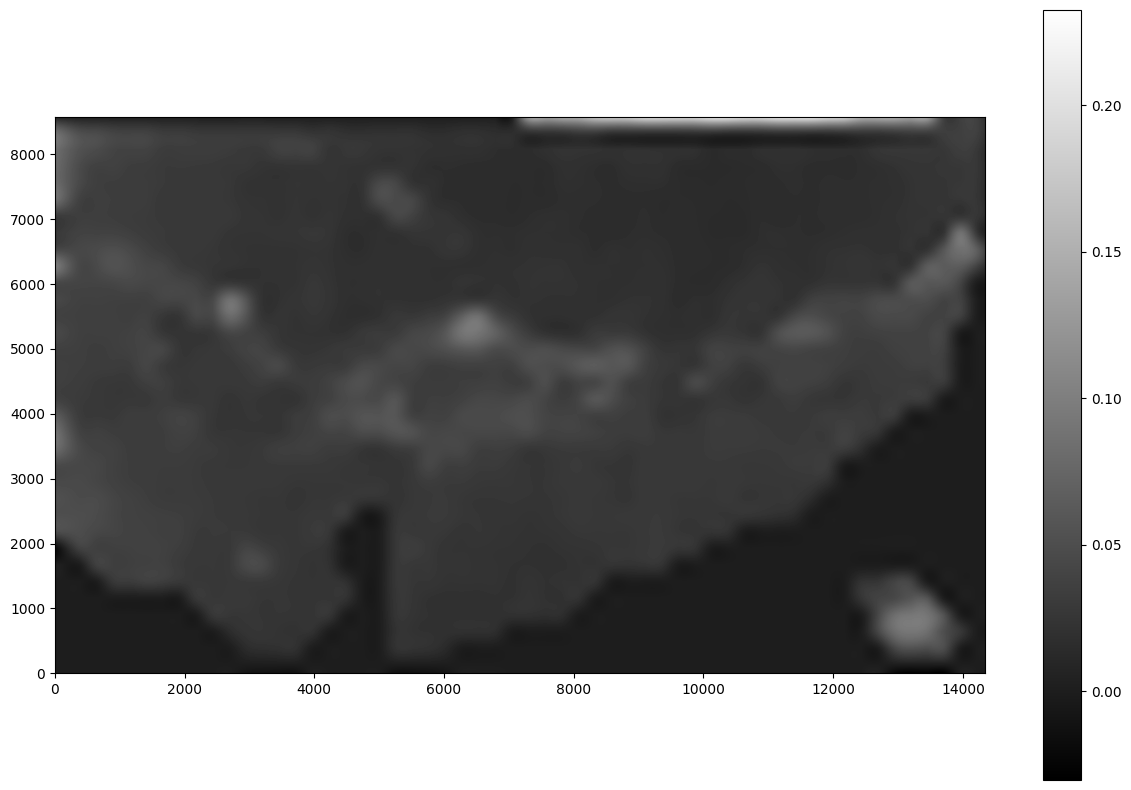

In [11]:
# show the background noise and save the image into a PNG file
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('NGC3324BackgroundNoise.png')

## Object Detection
In order to do object detection, we first subtract the background from the data.

In [12]:
#subtract the background
data_sub = data - bkg

In [13]:
# extract sources/objects from the image
objects = sep.extract(data_sub, 50, err=bkg.globalrms)

In [14]:
# how many objects were detected
print(f'Detected {len(objects)} objects')

Detected 2209 objects


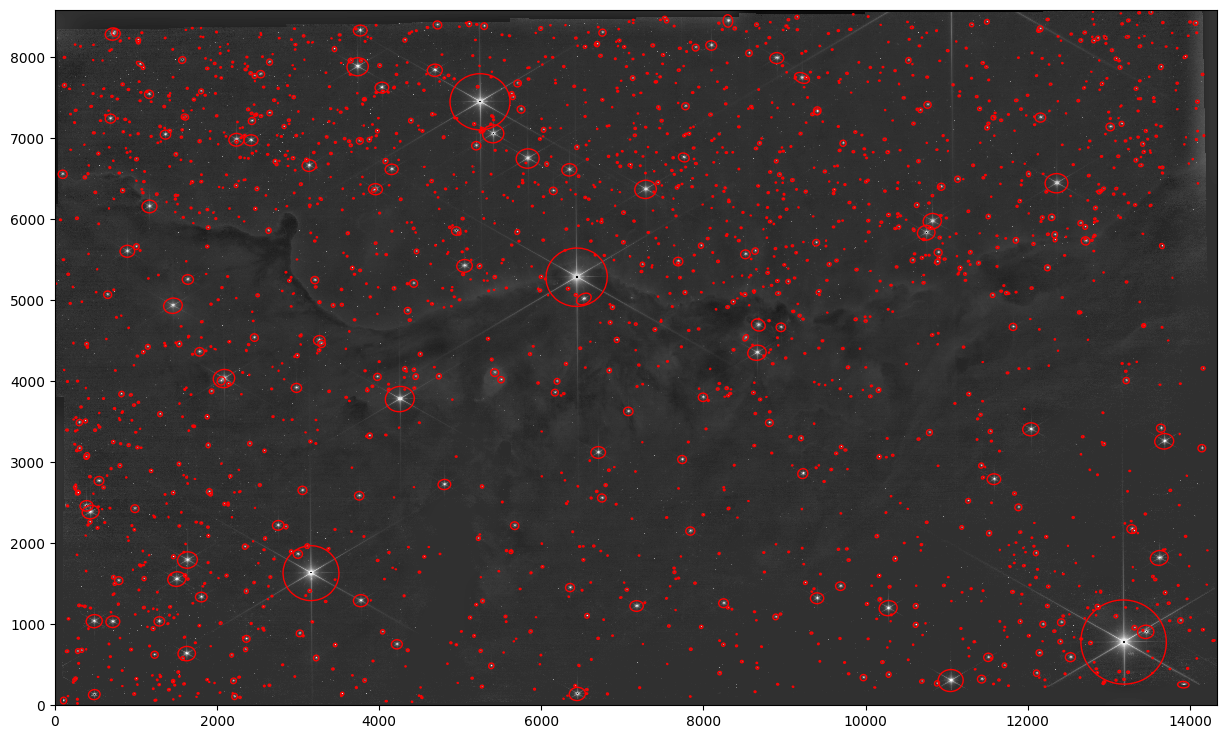

In [15]:
# draw an ellipse around each idenitified object and save the plot as a PNG file
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=20*objects['a'][i],
                height=20*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('NGC3324IdenitifiedObjects.png')

In [16]:
# check the available fields of the source
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## Aperture Photometry for Flux Calculation
We now perform a simple circular aperture photometry with a 3 pixel radius at the locations of each identified source to calculate the flux

In [17]:
# calculate the flux
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [18]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 33.901964 +/- 5.823965
object 1: flux = 31.547637 +/- 5.618208
object 2: flux = 37.718353 +/- 6.142871
object 3: flux = 34.979818 +/- 5.915779
object 4: flux = 41.592323 +/- 6.450496
object 5: flux = 54.218162 +/- 7.364419
object 6: flux = 27.418488 +/- 5.237849
object 7: flux = 39.668952 +/- 6.299651
object 8: flux = 27.389524 +/- 5.235081
object 9: flux = 40.761994 +/- 6.385810


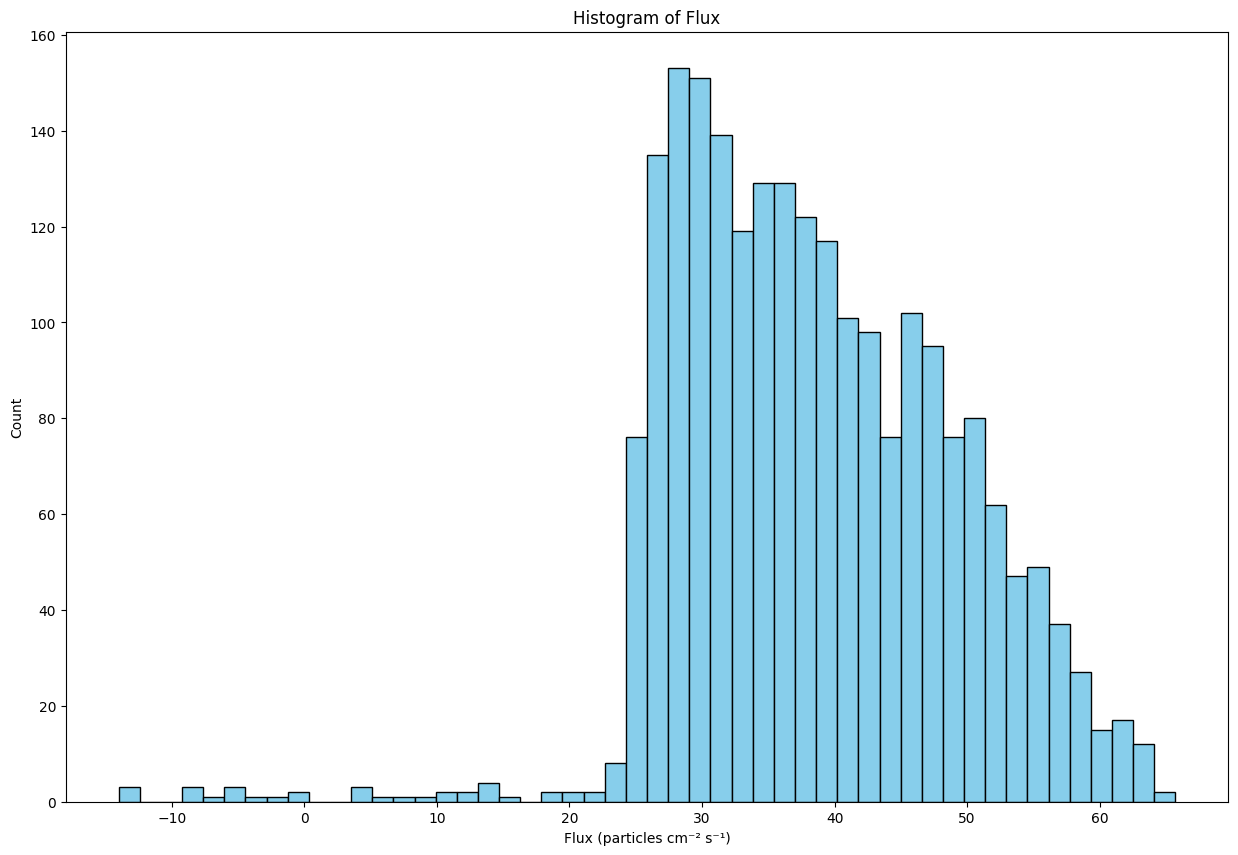

In [19]:
## Part 6: Show histograms of flux
bins = 50
plt.hist(flux, bins=bins, edgecolor='black', color='skyblue')
plt.xlabel('Flux (particles cm⁻² s⁻¹)')
plt.ylabel('Count')
plt.title("Histogram of Flux")
plt.savefig('NGC3324FluxHistogram.png', bbox_inches='tight', dpi=600)

In [20]:
## Part 7: mean, median, and standard deviation of the distribution of fluxes
meanFlux = np.mean(flux)
medianFlux = np.median(flux)
stdFlux = np.std(flux)
print(f"Mean of flux values: {meanFlux:.2f}")
print(f"Median of flux values: {medianFlux:.2f}")
print(f"Standard deviation of flux values: {stdFlux:.2f}")
print(f"This means that about 68% of the flux is within {stdFlux:.2f} around the mean {meanFlux:.2f}")
minFlux = np.min(flux)
maxFlux = np.max(flux)
if np.abs(minFlux - meanFlux) > np.abs(maxFlux - meanFlux):
    largestOutlier = minFlux
else:
    largestOutlier = maxFlux
print(f"Largest outlier flux in terms of deviation from mean: {largestOutlier:.2f}")
print(f"Largest outlier flux is {np.abs(largestOutlier-meanFlux)/stdFlux:.2f} standard deviations from mean")

Mean of flux values: 38.45
Median of flux values: 37.39
Standard deviation of flux values: 10.45
This means that about 68% of the flux is within 10.45 around the mean 38.45
Largest outlier flux in terms of deviation from mean: -14.01
Largest outlier flux is 5.02 standard deviations from mean


## Reproject
This code reprojects all images onto the same shape using one image as a reference. It has been commented because I already generated the reprojected files before and stored it as it takes a lot of time to generate. Now I just load those files.

In [21]:
## ################################
# Beginning of reproject script
# ---------------------------------
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

'''
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
#    This will define the WCS and shape for all others
# ---------------------------------
# Specify path to clear-f090w fits file
file_reference = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits'
with fits.open(file_reference) as hdulist:
    # For JWST i2d images, 'SCI' is commonly the science extension
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------
# 2. Reproject the other images
# ---------------------------------
fname1 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d.fits' # [PATH TO OTHER FITS FILE HERE]
fname2 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d.fits' # [PATH TO OTHER FITS FILE HERE]
fname3 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d.fits' # [PATH TO OTHER FITS FILE HERE]
fname4 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d.fits' # [PATH TO OTHER FITS FILE HERE]
fname5 = 'MAST/JWST/jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits' # [PATH TO OTHER FITS FILE HERE]

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        orig_data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)
    
    # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
    reprojected_data, footprint = reproject_interp(
        (orig_data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

    # Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
    new_header = ref_header.copy()

    # Save the new file
    out_name = fname.replace('.fits', '_reproj.fits')
    hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
    hdu.writeto(out_name, overwrite=True)
    print(f"Reprojected {fname} -> {out_name}")
# End of reproject script
## ################################
'''
print()

## NGC 3324 Image Generation
Create a 3-color false image of the NGC 3324 by combining all 6 images from the 6 data files

(8582, 14339, 3)
(8582, 14339, 3)


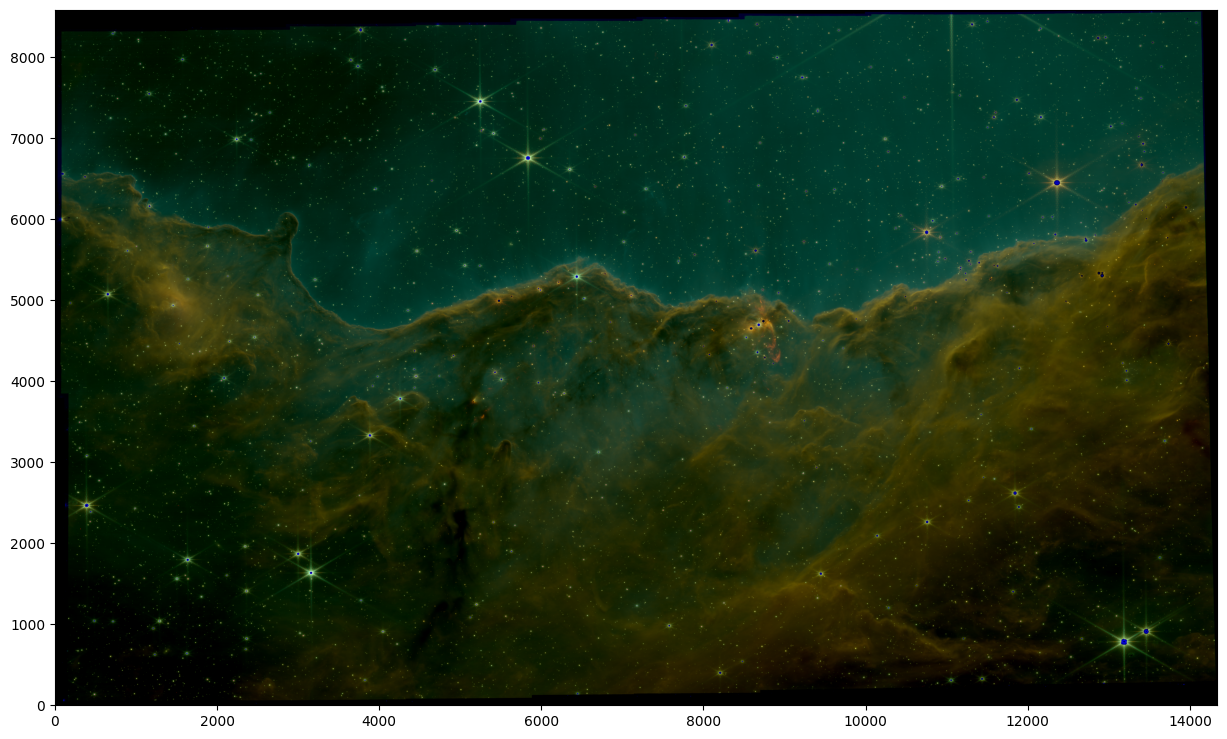

In [22]:
# Now, load the reprojected images

reproj_fname1 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits' # [PATH TO OTHER FITS FILE HERE]
reproj_fname2 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits' # [PATH TO OTHER FITS FILE HERE]
reproj_fname3 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits' # [PATH TO OTHER FITS FILE HERE]
reproj_fname4 = 'MAST/JWST/jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits' # [PATH TO OTHER FITS FILE HERE]
reproj_fname5 = 'MAST/JWST/jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits' # [PATH TO OTHER FITS FILE HERE]

hdu1 = fits.open(reproj_fname1)
hdu2 = fits.open(reproj_fname2)
hdu3 = fits.open(reproj_fname3)
hdu4 = fits.open(reproj_fname4)
hdu5 = fits.open(reproj_fname5)

data1 = hdu1['SCI'].data
data2 = hdu2['SCI'].data
data3 = hdu3['SCI'].data
data4 = hdu4['SCI'].data
data5 = hdu5['SCI'].data

# use the recommended palette for false 3-color images using different colors 
# for the 6 data files
data_all = np.zeros((data.shape[0], data.shape[1], 3))
data_all[:,:,2] = data + 0.5 * data1                                # Contributions to blue
data_all[:,:,1] = data2 + 0.5 * data1 + 0.5 * data3 + 0.40 * data4  # Contributions to green
data_all[:,:,0] = data5 + 0.6 * data4 + 0.5 * data3                 # Contributions to red

data_all_res = rescale_image(data_all)
print(np.shape(data_all_res))


def remap(data):
    # copy the data to avoid accidently overwriting it
    data_tmp = data.copy()
    dmin = data_tmp.min()
    dmax = data_tmp.max()
    return (data_tmp - dmin)/(dmax - dmin)


## TO FIX: Create the final rgb image using all six images
## Right now, we are just using the first three images as the R, G, and B components of the final image

rgb_image = remap(data_all_res[:,:,0:3])
print(np.shape(rgb_image))

plt.imshow(rgb_image, origin='lower')
plt.savefig('NGC3324RGBImage.png')
plt.show()